# Import Modules

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Load the Dataset

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.UVJXNL_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.UVJXNL_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.


In [ ]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/4.0.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed and
    species. Additionally, head bounding boxes are provided for the training split,
    allowing using this dataset for simple object detection tasks. In the test
    split, the bounding boxes are empty.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir='/root/tensorflow_datasets/oxford_iiit_pet/4.0.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=773.68 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'head_bbox': BBoxFeature(shape=(4,), dtype=float32),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLab

In [ ]:
dataset

{'train': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'head_bbox': TensorSpec(shape=(4,), dtype=tf.float32, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 'test': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'head_bbox': TensorSpec(shape=(4,), dtype=tf.float32, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}

# Preprocessing Steps

In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask = input_mask - 1 # convert to zero based indexing
  return input_image, input_mask

def load_train_images(sample):
  # resize the image
  input_image = tf.image.resize(sample['image'], (128, 128))
  input_mask = tf.image.resize(sample['segmentation_mask'], (128, 128))
  # data augmentation
  if tf.random.uniform(()) > 0.5:
      input_image = tf.image.flip_left_right(input_image)
      input_mask = tf.image.flip_left_right(input_mask)
  # normalize the images
  input_image, input_mask = normalize(input_image, input_mask)
  return input_image, input_mask

def load_test_images(sample):
  # resize the image
  input_image = tf.image.resize(sample['image'], (128, 128))
  input_mask = tf.image.resize(sample['segmentation_mask'], (128, 128))
  # normalize the images
  input_image, input_mask = normalize(input_image, input_mask)
  return input_image, input_mask

In [ ]:
train_dataset = dataset['train'].map(load_train_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = dataset['test'].map(load_test_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)

# EDA

In [ ]:
def display_sample(image_list):
  plt.figure(figsize=(10,10))
  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(image_list)):
    plt.subplot(1, len(image_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(image_list[i]))
    plt.axis('off')

  plt.show()

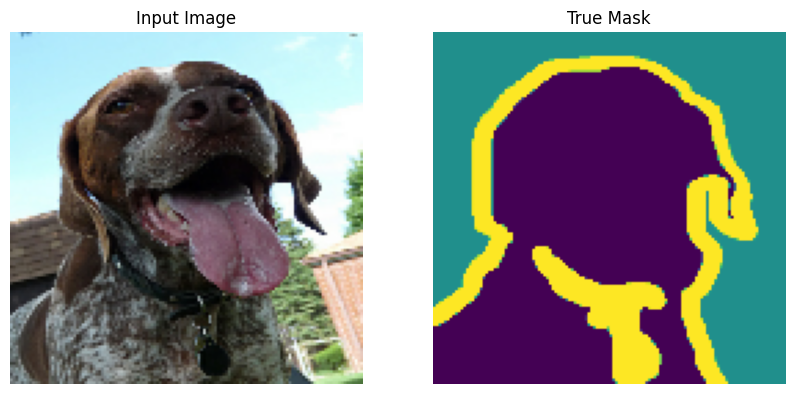

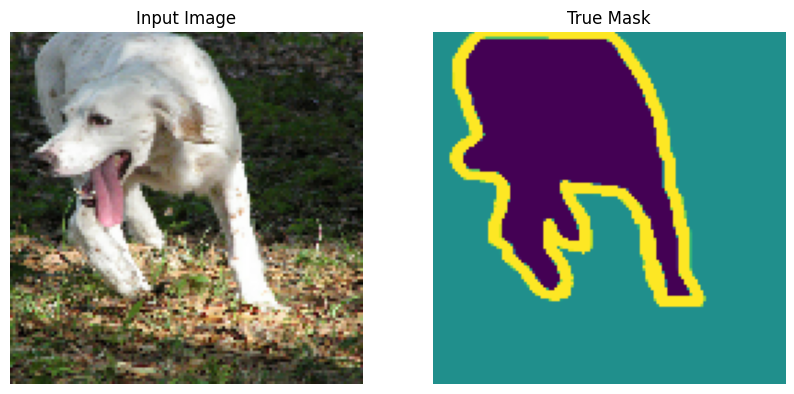

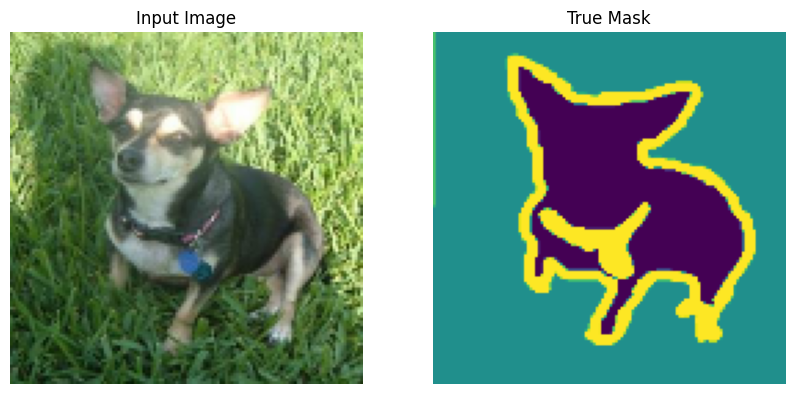

In [ ]:
for images, masks in train_dataset.take(3):
  sample_image, sample_mask = images[0], masks[0]
  display_sample([sample_image, sample_mask])

# Define U-NET Model

In [ ]:
def double_conv_block(x, n_filters):
  x = layers.Conv2D(n_filters, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
  x = layers.Conv2D(n_filters, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
  return x

def downsample_block(x, n_filters):
  f = double_conv_block(x, n_filters)
  p = layers.MaxPool2D(2)(f)
  p = layers.Dropout(0.3)(p)
  return f, p

def upsample_block(x, conv_features, n_filters):
  x = layers.Conv2DTranspose(n_filters, 3, 2, padding='same')(x)
  x = layers.concatenate([x, conv_features])
  x = layers.Dropout(0.3)(x)
  x = double_conv_block(x, n_filters)
  return x

In [ ]:
def build_unet_model(output_channels):
  # input layer
  inputs = layers.Input(shape=(128, 128, 3))

  # encoder - downsample
  f1, p1 = downsample_block(inputs, 64)
  f2, p2 = downsample_block(p1, 128)
  f3, p3 = downsample_block(p2, 256)
  f4, p4 = downsample_block(p3, 512)

  # intermediate block
  intermediate_block = double_conv_block(p4, 1024)

  # decoder - upsample
  u6 = upsample_block(intermediate_block, f4, 512)
  u7 = upsample_block(u6, f3, 256)
  u8 = upsample_block(u7, f2, 128)
  u9 = upsample_block(u8, f1, 64)

  # output layer
  outputs = layers.Conv2D(output_channels, 1, padding='same', activation='softmax')(u9)

  # unet model
  unet_model = tf.keras.Model(inputs, outputs, name='U-Net')

  return unet_model

In [ ]:
output_channels = 3
model = build_unet_model(output_channels)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 64,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 32,    │          0 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ dropout_1[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 16, 16,    │          0 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ dropout_2[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 8, 8, 512) │          0 │ max_pooling2d_3[

 Total params: 34,513,475 (131.66 MB)

 Trainable params: 34,513,475 (131.66 MB)

 Non-trainable params: 0 (0.00 B)

# Train the model

In [ ]:
EPOCHS = 20
steps_per_epoch = info.splits['train'].num_examples // BATCH_SIZE
validation_steps = info.splits['test'].num_examples // BATCH_SIZE

history = model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, validation_data=test_dataset)

Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.5614 - loss: 1.0051 - val_accuracy: 0.6236 - val_loss: 0.7994
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.6760 - loss: 0.7504 - val_accuracy: 0.7205 - val_loss: 0.6790
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.7242 - loss: 0.6565 - val_accuracy: 0.7583 - val_loss: 0.5820
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.7552 - loss: 0.5879 - val_accuracy: 0.7659 - val_loss: 0.5721
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7732 - loss: 0.5502 - val_accuracy: 0.7910 - val_loss: 0.5070
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7903 - loss: 0.5060 - val_accuracy: 0.8101 - val_loss: 0.4589
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.8113 - loss: 0.4579 - val_accuracy: 0.8239 - val_loss: 0.4306
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8195 - loss: 0.4398 - val_accuracy: 0.8262 - val_los

# Visualize the Results

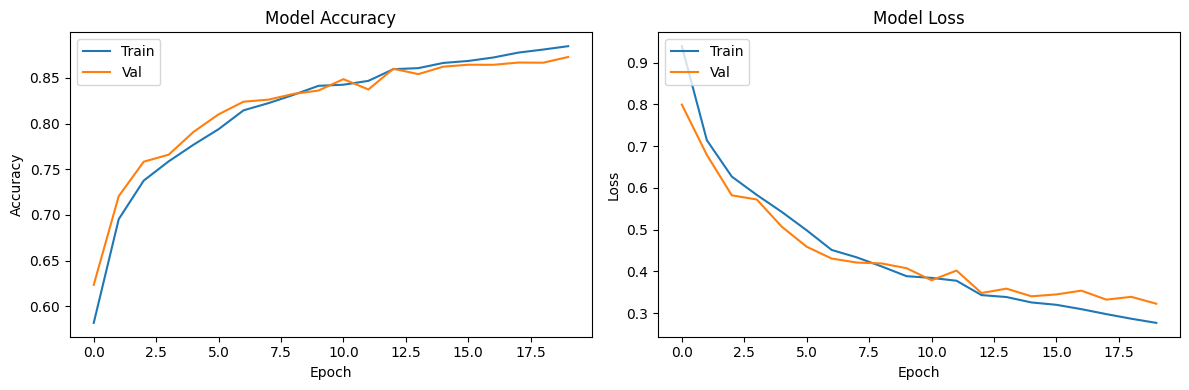

In [ ]:
# plot train & val accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')

# plot train & val loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()

# Test Predictions

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display_sample([image[0], mask[0], create_mask(pred_mask)])

2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 181ms/step


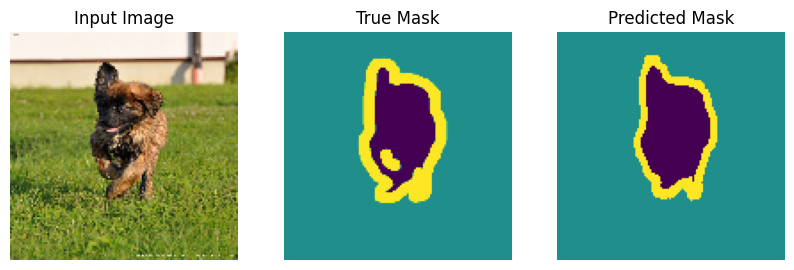

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


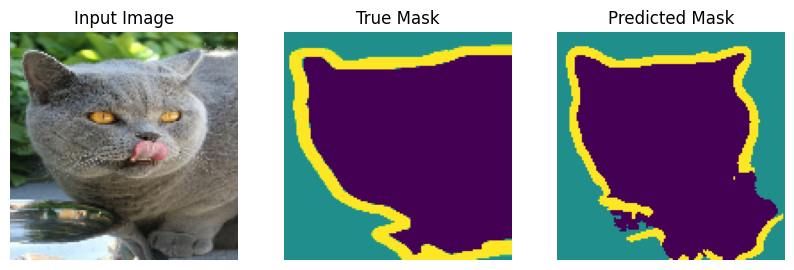

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


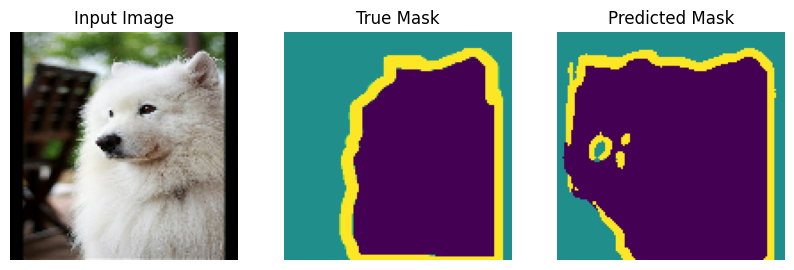

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


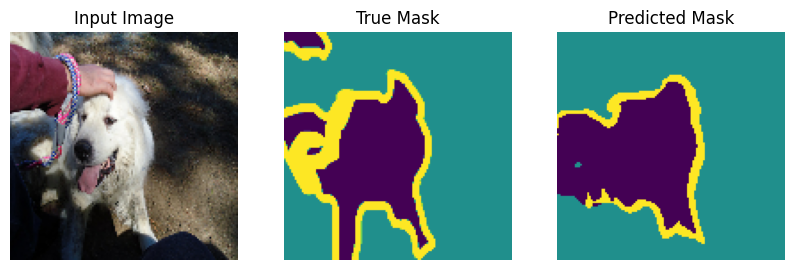

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


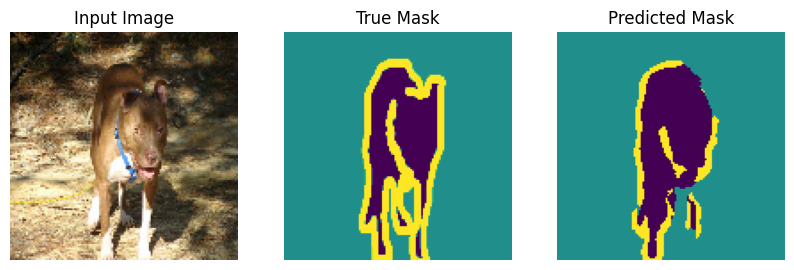

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


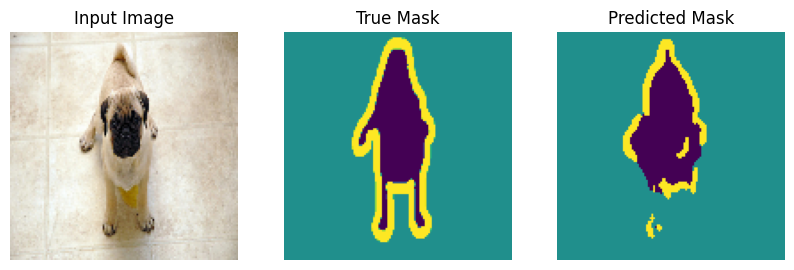

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


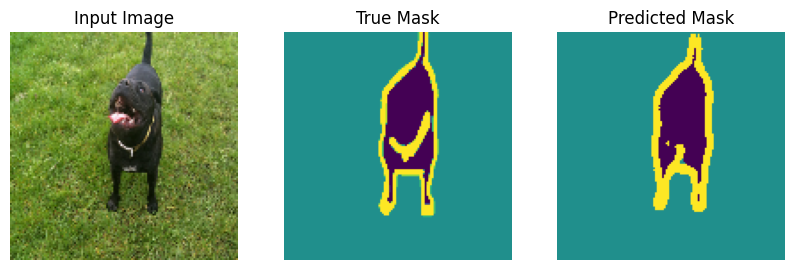

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


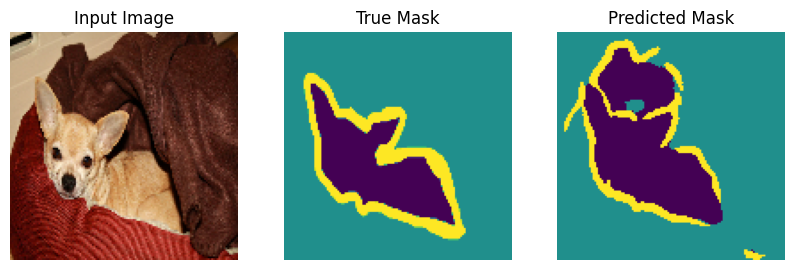

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


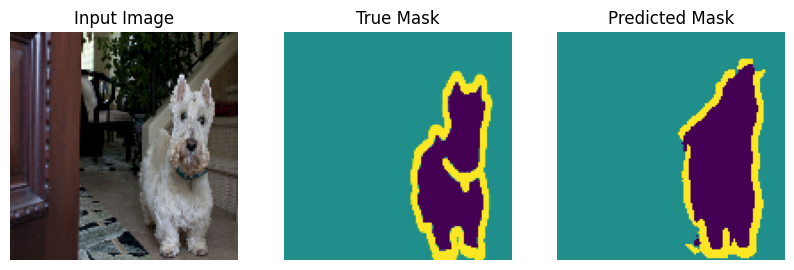

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


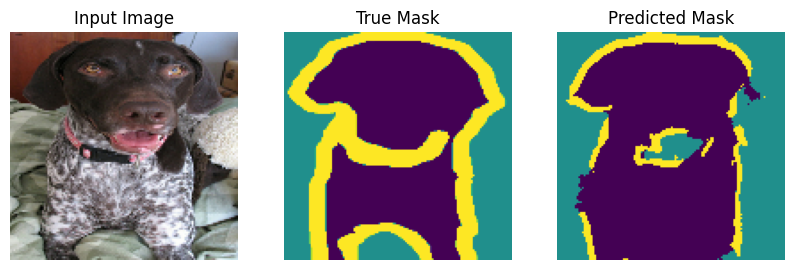

In [ ]:
show_predictions(test_dataset, 10)